In [102]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


In [103]:
# Load the model-ready dataset
df = pd.read_csv('../data/model_ready_data.csv')
df['Date'] = pd.to_datetime(df['Date'])

print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Date Range: {df['Date'].min().date()} to {df['Date'].max().date()}")
print(f"\nCrops: {df['item'].unique().tolist()}")
print(f"Markets: {df['market'].nunique()} unique markets")
print(f"\nColumns:")
print(df.columns.tolist())

Dataset Shape: 109,620 rows × 32 columns
Date Range: 2020-01-01 to 2024-12-31

Crops: ['Beetroot', 'Raddish', 'Red Onion', 'Rice']
Markets: 15 unique markets

Columns:
['Date', 'market', 'item', 'price', 'volume_MT', 'temperature_avg_C', 'temperature_min_C', 'temperature_max_C', 'rainfall_mm', 'humidity_percent', 'wind_speed_kmh', 'season', 'cultivation_season', 'harvest_period_rice', 'vegetable_peak_season', 'is_public_holiday', 'is_day_before_holiday', 'near_major_holiday', 'demand_multiplier', 'day_of_week', 'day_of_month', 'day_of_year', 'week_of_year', 'month', 'quarter', 'year', 'is_weekend', 'is_month_end', 'price_lag_1', 'price_lag_7', 'price_rolling_7_mean', 'volume_lag_1']


In [104]:
# Check for missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing': missing, 'Percentage': missing_pct})
print("Missing Values:")
print(missing_df[missing_df['Missing'] > 0])

Missing Values:
Empty DataFrame
Columns: [Missing, Percentage]
Index: []


---
## Feature Engineering

In [105]:
# Create a copy for modeling
df_model = df.copy()

# Encode categorical variables
le_item = LabelEncoder()
le_market = LabelEncoder()
le_season = LabelEncoder()
le_cultivation = LabelEncoder()

df_model['item_encoded'] = le_item.fit_transform(df_model['item'])
df_model['market_encoded'] = le_market.fit_transform(df_model['market'])
df_model['season_encoded'] = le_season.fit_transform(df_model['season'])
df_model['cultivation_encoded'] = le_cultivation.fit_transform(df_model['cultivation_season'])

# Create item and market mapping for later use
item_mapping = dict(zip(le_item.classes_, le_item.transform(le_item.classes_)))
market_mapping = dict(zip(le_market.classes_, le_market.transform(le_market.classes_)))

print("Item Encoding:")
for item, code in item_mapping.items():
    print(f"  {item}: {code}")

print(f"\nMarkets encoded: {len(market_mapping)} markets")

Item Encoding:
  Beetroot: 0
  Raddish: 1
  Red Onion: 2
  Rice: 3

Markets encoded: 15 markets


In [106]:
# Define features for the model
feature_cols = [
    # Encoded categorical features
    'item_encoded', 'market_encoded', 'season_encoded', 'cultivation_encoded',
    
    # Weather features
    'temperature_avg_C', 'temperature_min_C', 'temperature_max_C',
    'rainfall_mm', 'humidity_percent', 'wind_speed_kmh',
    
    # Time features
    'day_of_week', 'day_of_month', 'day_of_year', 'week_of_year', 'month', 'quarter', 'year',
    
    # Seasonal features
    'harvest_period_rice', 'vegetable_peak_season', 'is_weekend', 'is_month_end',
    
    # Holiday features
    'is_public_holiday', 'is_day_before_holiday', 'near_major_holiday', 'demand_multiplier',
    
    # Lag features (historical data)
    'price_lag_1', 'price_lag_7', 'price_rolling_7_mean', 'volume_lag_1'
]

# Target variable
target = 'price'

# Check which features are available
available_features = [col for col in feature_cols if col in df_model.columns]
missing_features = [col for col in feature_cols if col not in df_model.columns]

print(f"Available features: {len(available_features)}")
if missing_features:
    print(f"Missing features: {missing_features}")

# Use only available features
feature_cols = available_features
print(f"\nFeatures to use ({len(feature_cols)}):")
for f in feature_cols:
    print(f"  • {f}")

Available features: 29

Features to use (29):
  • item_encoded
  • market_encoded
  • season_encoded
  • cultivation_encoded
  • temperature_avg_C
  • temperature_min_C
  • temperature_max_C
  • rainfall_mm
  • humidity_percent
  • wind_speed_kmh
  • day_of_week
  • day_of_month
  • day_of_year
  • week_of_year
  • month
  • quarter
  • year
  • harvest_period_rice
  • vegetable_peak_season
  • is_weekend
  • is_month_end
  • is_public_holiday
  • is_day_before_holiday
  • near_major_holiday
  • demand_multiplier
  • price_lag_1
  • price_lag_7
  • price_rolling_7_mean
  • volume_lag_1


In [107]:
# Prepare X and y
X = df_model[feature_cols].copy()
y = df_model[target].copy()

# Handle any remaining NaN values
X = X.fillna(X.median())

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget statistics:")
print(f"  Mean: {y.mean():.2f}")
print(f"  Std: {y.std():.2f}")
print(f"  Min: {y.min():.2f}")
print(f"  Max: {y.max():.2f}")

Features shape: (109620, 29)
Target shape: (109620,)

Target statistics:
  Mean: 251.52
  Std: 158.29
  Min: 31.86
  Max: 902.34


---
## Train-Test Split (Time-Based)

In [108]:
# Time-based split (use last 20% for testing to simulate real forecasting)
split_idx = int(len(X) * 0.8)

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

# Get dates for reference
train_dates = df_model['Date'].iloc[:split_idx]
test_dates = df_model['Date'].iloc[split_idx:]

print(f"Training set: {len(X_train):,} samples")
print(f"  Date range: {train_dates.min().date()} to {train_dates.max().date()}")
print(f"\nTest set: {len(X_test):,} samples")
print(f"  Date range: {test_dates.min().date()} to {test_dates.max().date()}")

Training set: 87,696 samples
  Date range: 2020-01-01 to 2024-01-01

Test set: 21,924 samples
  Date range: 2024-01-01 to 2024-12-31

  Date range: 2020-01-01 to 2024-01-01

Test set: 21,924 samples
  Date range: 2024-01-01 to 2024-12-31


In [109]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully!")

Features scaled successfully!


---
## Model 1: Random Forest Regressor

In [110]:
# Train Random Forest model
print("Training Random Forest model...")

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
print("Random Forest model trained!")

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation metrics
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)
rf_mape = np.mean(np.abs((y_test - y_pred_rf) / y_test)) * 100

print("RANDOM FOREST RESULTS")
print(f"MAE:  {rf_mae:.2f} LKR")
print(f"RMSE: {rf_rmse:.2f} LKR")
print(f"R²:   {rf_r2:.4f}")
print(f"MAPE: {rf_mape:.2f}%")

Training Random Forest model...
Random Forest model trained!
RANDOM FOREST RESULTS
MAE:  32.26 LKR
RMSE: 47.02 LKR
R²:   0.9295
MAPE: 11.54%
Random Forest model trained!
RANDOM FOREST RESULTS
MAE:  32.26 LKR
RMSE: 47.02 LKR
R²:   0.9295
MAPE: 11.54%


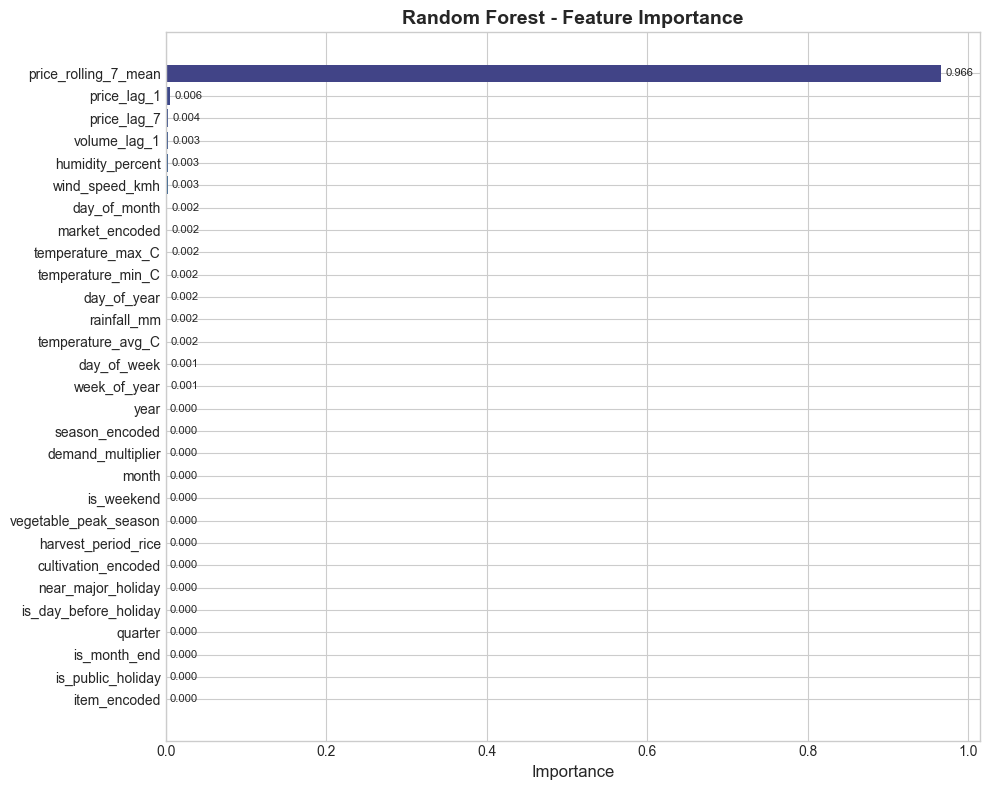


Top 10 Most Important Features:
             Feature  Importance
price_rolling_7_mean    0.966331
         price_lag_1    0.005520
         price_lag_7    0.003576
        volume_lag_1    0.003327
    humidity_percent    0.002642
      wind_speed_kmh    0.002554
        day_of_month    0.002034
      market_encoded    0.001915
   temperature_max_C    0.001815
   temperature_min_C    0.001691


In [111]:
# Feature importance for Random Forest
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(feature_importance)))
bars = ax.barh(feature_importance['Feature'], feature_importance['Importance'], color=colors)
ax.set_xlabel('Importance', fontsize=12)
ax.set_title('Random Forest - Feature Importance', fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add value labels
for bar, val in zip(bars, feature_importance['Importance']):
    ax.text(val + 0.005, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

---
## Model 2: Gradient Boosting Regressor

In [112]:
# Train Gradient Boosting model
print("Training Gradient Boosting model...")

gb_model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=8,
    learning_rate=0.1,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

gb_model.fit(X_train, y_train)
print("Gradient Boosting model trained!")

# Predictions
y_pred_gb = gb_model.predict(X_test)

# Evaluation metrics
gb_mae = mean_absolute_error(y_test, y_pred_gb)
gb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb))
gb_r2 = r2_score(y_test, y_pred_gb)
gb_mape = np.mean(np.abs((y_test - y_pred_gb) / y_test)) * 100

print(f"\n{'='*50}")
print("GRADIENT BOOSTING RESULTS")
print(f"{'='*50}")
print(f"MAE:  {gb_mae:.2f} LKR")
print(f"RMSE: {gb_rmse:.2f} LKR")
print(f"R²:   {gb_r2:.4f}")
print(f"MAPE: {gb_mape:.2f}%")

Training Gradient Boosting model...
Gradient Boosting model trained!

GRADIENT BOOSTING RESULTS
MAE:  32.38 LKR
RMSE: 47.46 LKR
R²:   0.9282
MAPE: 11.52%
Gradient Boosting model trained!

GRADIENT BOOSTING RESULTS
MAE:  32.38 LKR
RMSE: 47.46 LKR
R²:   0.9282
MAPE: 11.52%


## Model 3: LSTM (Time Series Deep Learning)


In [113]:
# Prepare data for LSTM (need to create sequences)
def create_sequences(data, target, seq_length=7):
    """
    Create sequences for LSTM input.
    seq_length = number of time steps to look back
    """
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i+seq_length])
        y_seq.append(target[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

# We'll train separate LSTM models for each crop for better accuracy
SEQ_LENGTH = 7  # Reduced from 14 to 7 days (more sequences available)

print(f"Sequence length: {SEQ_LENGTH} days")
print("Preparing LSTM data for each crop...")

Sequence length: 7 days
Preparing LSTM data for each crop...


In [114]:
# Prepare LSTM data - aggregate by date and crop (average across markets)
lstm_data = df_model.groupby(['Date', 'item']).agg({
    'price': 'mean',
    'volume_MT': 'mean',
    'temperature_avg_C': 'mean',
    'rainfall_mm': 'mean',
    'humidity_percent': 'mean',
    'month': 'first',
    'day_of_week': 'first',
    'is_public_holiday': 'max',
    'demand_multiplier': 'mean'
}).reset_index()

lstm_data = lstm_data.sort_values(['item', 'Date']).reset_index(drop=True)
print(f"LSTM data shape: {lstm_data.shape}")
print(f"Crops: {lstm_data['item'].unique().tolist()}")

LSTM data shape: (7308, 11)
Crops: ['Beetroot', 'Raddish', 'Red Onion', 'Rice']


In [115]:
# Build and train LSTM model for each crop
def build_lstm_model(input_shape, units=64):
    """Build a Bidirectional LSTM model"""
    model = Sequential([
        Bidirectional(LSTM(units, return_sequences=True), input_shape=input_shape),
        Dropout(0.3),
        Bidirectional(LSTM(units // 2, return_sequences=False)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1)  # Output layer predicts scaled price
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model

# Feature columns for LSTM (include price as a feature for autoregressive prediction)
lstm_features = ['price', 'volume_MT', 'temperature_avg_C', 'rainfall_mm', 
                 'humidity_percent', 'month', 'day_of_week', 'is_public_holiday', 'demand_multiplier']

print("LSTM Model Architecture:")
print("  • Bidirectional LSTM (64 units)")
print("  • Dropout (0.3)")
print("  • Bidirectional LSTM (32 units)")
print("  • Dropout (0.3)")
print("  • Dense (32 units, ReLU)")
print("  • Dense (16 units, ReLU)")
print("  • Dense (1 unit, output)")


LSTM Model Architecture:
  • Bidirectional LSTM (64 units)
  • Dropout (0.3)
  • Bidirectional LSTM (32 units)
  • Dropout (0.3)
  • Dense (32 units, ReLU)
  • Dense (16 units, ReLU)
  • Dense (1 unit, output)


In [116]:
# Train LSTM for each crop - WITH PROPER SCALING
lstm_results = {}
lstm_models = {}
lstm_scalers = {}
lstm_target_scalers = {}  # NEW: Separate scaler for target variable

crops_list = lstm_data['item'].unique().tolist()
print(f"Training LSTM for {len(crops_list)} crops: {crops_list}\n")

for crop in crops_list:
    print(f"{'='*60}")
    print(f"Training LSTM for: {crop}")
    print('='*60)
    
    # Get crop data
    crop_df = lstm_data[lstm_data['item'] == crop].copy()
    crop_df = crop_df.sort_values('Date').reset_index(drop=True)
    
    print(f"  Data points: {len(crop_df)}")
    
    # Prepare features and target
    X_crop = crop_df[lstm_features].values
    y_crop = crop_df['price'].values.reshape(-1, 1)  # Reshape for scaler
    
    # Scale features
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X_crop)
    lstm_scalers[crop] = scaler_X
    
    # Scale target (IMPORTANT FIX!)
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y_crop).flatten()
    lstm_target_scalers[crop] = scaler_y
    
    # Create sequences with scaled target
    X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LENGTH)
    
    print(f"  Total sequences: {len(X_seq)}")
    
    # Time-based split (80% train, 20% test)
    split = int(len(X_seq) * 0.8)
    X_train_lstm = X_seq[:split]
    X_test_lstm = X_seq[split:]
    y_train_lstm = y_seq[:split]
    y_test_lstm = y_seq[split:]
    
    print(f"  Train sequences: {X_train_lstm.shape}")
    print(f"  Test sequences: {X_test_lstm.shape}")
    
    # Build and train model
    model = build_lstm_model(input_shape=(SEQ_LENGTH, len(lstm_features)))
    
    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=0.00001, verbose=0)
    
    # Train with more epochs
    history = model.fit(
        X_train_lstm, y_train_lstm,
        epochs=100,  # Increased epochs
        batch_size=16,  # Smaller batch size
        validation_split=0.2,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )
    
    print(f"  Epochs trained: {len(history.history['loss'])}")
    
    # Predict (scaled output)
    y_pred_scaled = model.predict(X_test_lstm, verbose=0).flatten()
    
    # Inverse transform predictions and actual values back to original scale
    y_pred_original = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_test_original = scaler_y.inverse_transform(y_test_lstm.reshape(-1, 1)).flatten()
    
    # Evaluate on ORIGINAL scale
    mae = mean_absolute_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    r2 = r2_score(y_test_original, y_pred_original)
    mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100
    
    lstm_results[crop] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape,
        'y_test': y_test_original,  # Store original scale
        'y_pred': y_pred_original   # Store original scale
    }
    lstm_models[crop] = model
    
    print(f"  MAE: {mae:.2f} LKR")
    print(f"  RMSE: {rmse:.2f} LKR")
    print(f"  R²: {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    print()


Training LSTM for 4 crops: ['Beetroot', 'Raddish', 'Red Onion', 'Rice']

Training LSTM for: Beetroot
  Data points: 1827
  Total sequences: 1820
  Train sequences: (1456, 7, 9)
  Test sequences: (364, 7, 9)
  Epochs trained: 21
  Epochs trained: 21
  MAE: 9.89 LKR
  RMSE: 12.44 LKR
  R²: 0.5726
  MAPE: 3.83%

Training LSTM for: Raddish
  Data points: 1827
  Total sequences: 1820
  Train sequences: (1456, 7, 9)
  Test sequences: (364, 7, 9)
  MAE: 9.89 LKR
  RMSE: 12.44 LKR
  R²: 0.5726
  MAPE: 3.83%

Training LSTM for: Raddish
  Data points: 1827
  Total sequences: 1820
  Train sequences: (1456, 7, 9)
  Test sequences: (364, 7, 9)
  Epochs trained: 25
  Epochs trained: 25
  MAE: 4.17 LKR
  RMSE: 5.28 LKR
  R²: 0.6435
  MAPE: 3.79%

Training LSTM for: Red Onion
  Data points: 1827
  Total sequences: 1820
  Train sequences: (1456, 7, 9)
  Test sequences: (364, 7, 9)
  MAE: 4.17 LKR
  RMSE: 5.28 LKR
  R²: 0.6435
  MAPE: 3.79%

Training LSTM for: Red Onion
  Data points: 1827
  Total seque

In [117]:
# LSTM Results Summary
lstm_summary = pd.DataFrame(lstm_results).T
lstm_summary = lstm_summary[['MAE', 'RMSE', 'R2', 'MAPE']].round(4)
lstm_summary.columns = ['MAE (LKR)', 'RMSE (LKR)', 'R² Score', 'MAPE (%)']


print(lstm_summary.to_string())

# Average LSTM performance
avg_mae = lstm_summary['MAE (LKR)'].mean()
avg_rmse = lstm_summary['RMSE (LKR)'].mean()
avg_r2 = lstm_summary['R² Score'].mean()
avg_mape = lstm_summary['MAPE (%)'].mean()


print(f"Avg MAE:  {avg_mae:.2f} LKR")
print(f"Avg RMSE: {avg_rmse:.2f} LKR")
print(f"Avg R²:   {avg_r2:.4f}")
print(f"Avg MAPE: {avg_mape:.2f}%")

           MAE (LKR) RMSE (LKR)  R² Score  MAPE (%)
Beetroot    9.890613  12.439497  0.572609  3.833076
Raddish     4.173235   5.280305  0.643543  3.793652
Red Onion  22.452603  29.163009  0.585196  3.874674
Rice        9.858023    12.7445   0.54875  4.034103
Avg MAE:  11.59 LKR
Avg RMSE: 14.91 LKR
Avg R²:   0.5875
Avg MAPE: 3.88%


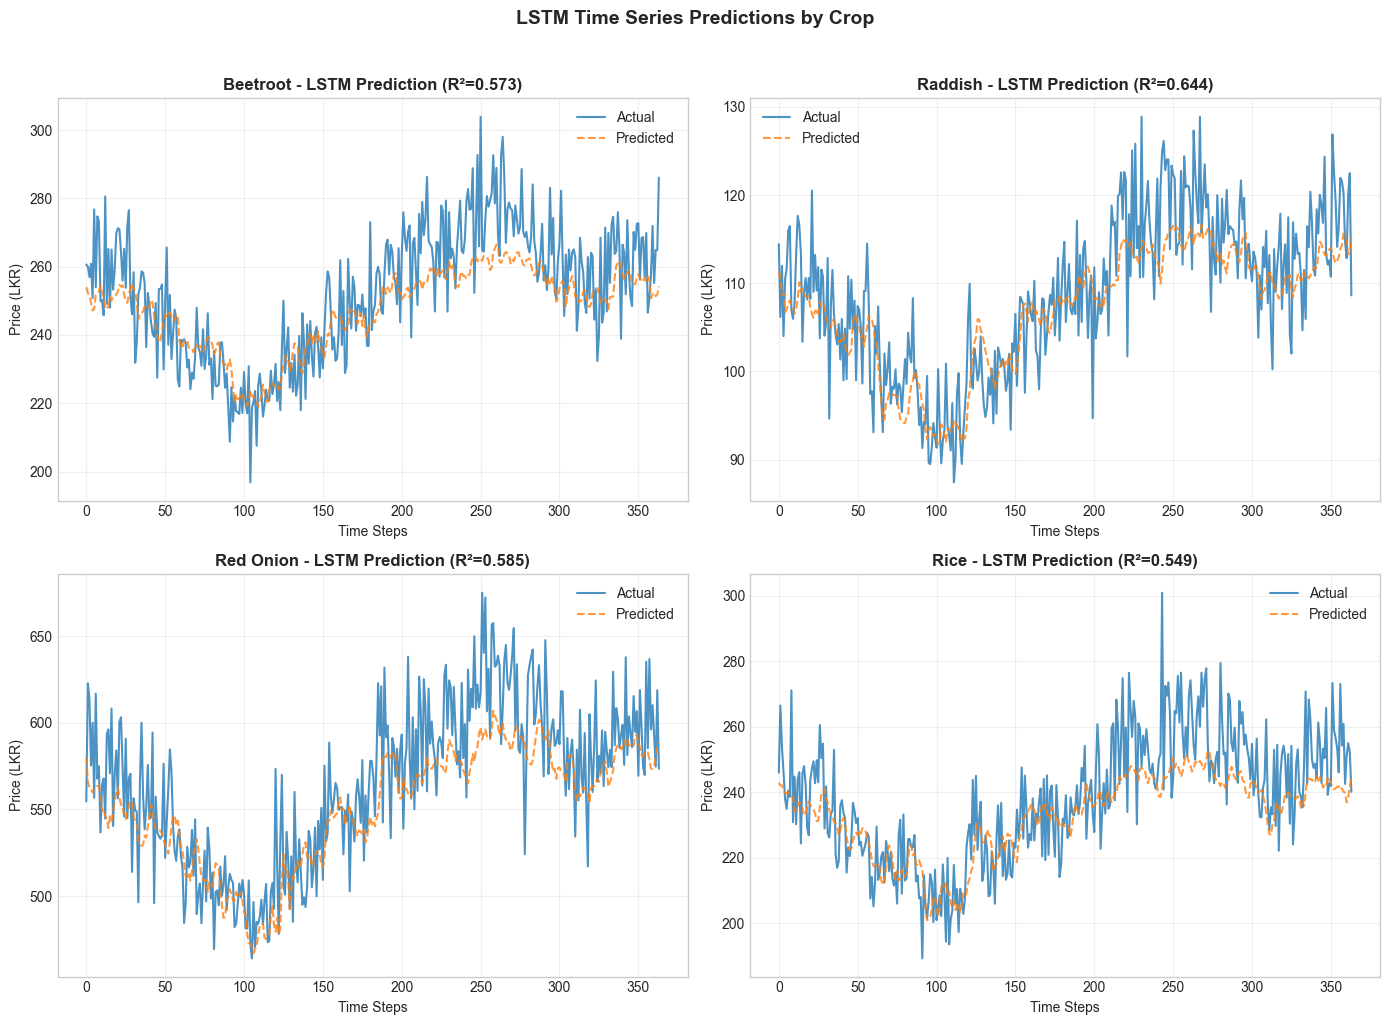

In [118]:
# Visualize LSTM predictions for each crop
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
colors = ['#2ecc71', '#e74c3c', '#3498db', '#9b59b6']

for idx, crop in enumerate(lstm_results.keys()):
    ax = axes[idx // 2, idx % 2]
    
    y_test = lstm_results[crop]['y_test']
    y_pred = lstm_results[crop]['y_pred']
    
    # Plot actual vs predicted over time
    ax.plot(range(len(y_test)), y_test, label='Actual', alpha=0.8, linewidth=1.5)
    ax.plot(range(len(y_pred)), y_pred, label='Predicted', alpha=0.8, linewidth=1.5, linestyle='--')
    
    r2 = lstm_results[crop]['R2']
    ax.set_title(f'{crop} - LSTM Prediction (R²={r2:.3f})', fontsize=12, fontweight='bold')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Price (LKR)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('LSTM Time Series Predictions by Crop', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## Models Comparison (RF vs GB vs LSTM)

            Model  MAE (LKR)  RMSE (LKR)  R² Score  MAPE (%)
    Random Forest  32.259093   47.019946  0.929526 11.537469
Gradient Boosting  32.383675   47.455368  0.928215 11.524626
       LSTM (Avg)  11.593619   14.906828  0.587525  3.883876


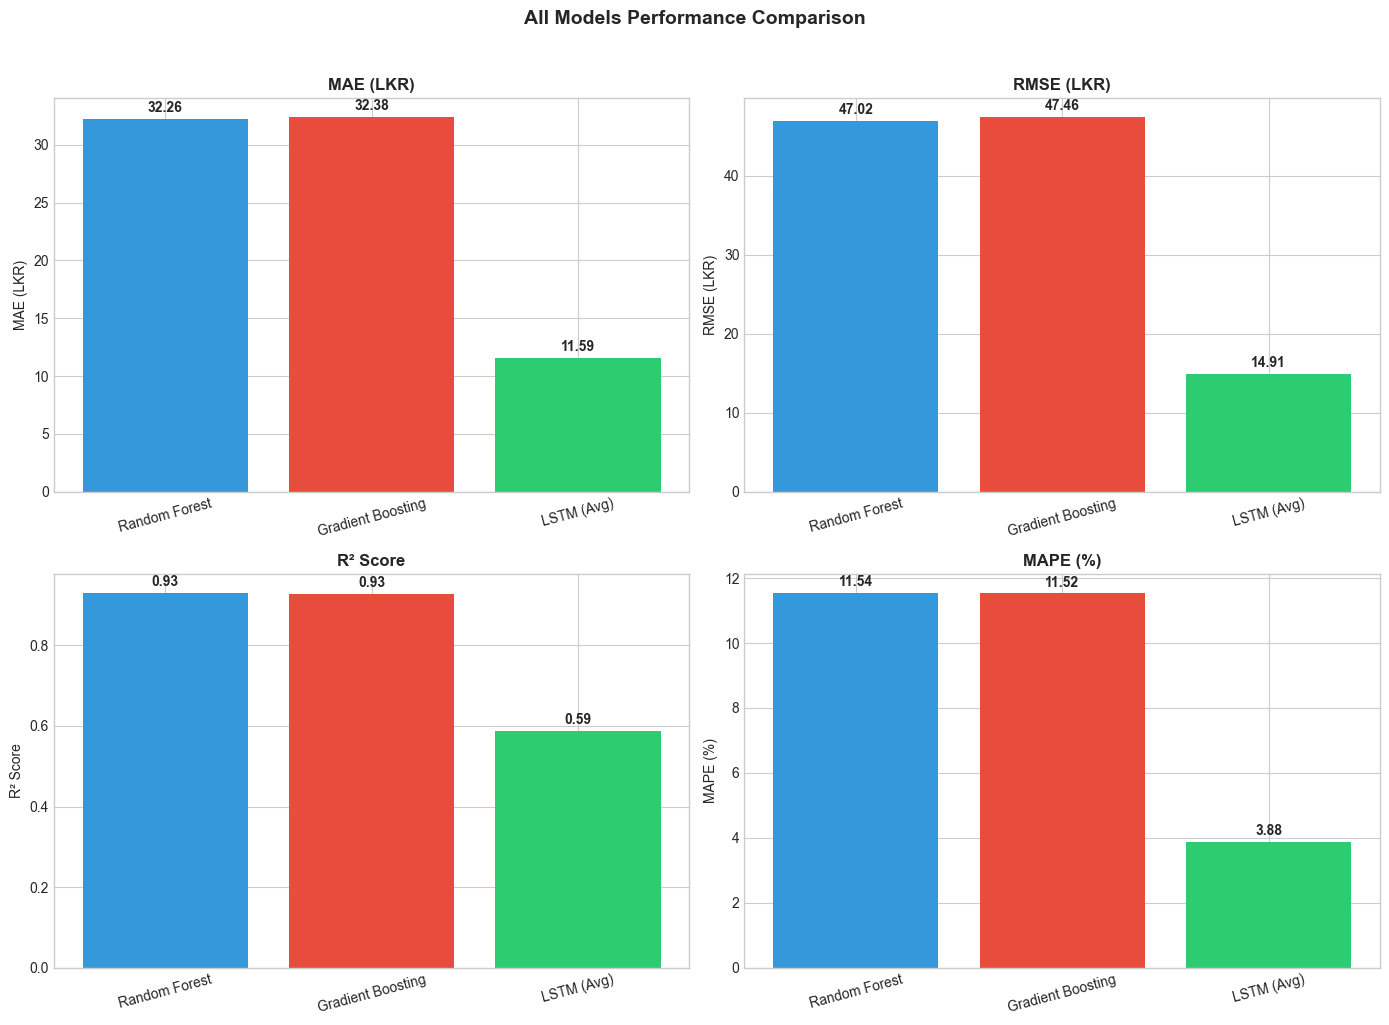


 BEST OVERALL MODEL (by RMSE): LSTM (Avg)


In [119]:
# Compare all three models
all_models_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting', 'LSTM (Avg)'],
    'MAE (LKR)': [rf_mae, gb_mae, avg_mae],
    'RMSE (LKR)': [rf_rmse, gb_rmse, avg_rmse],
    'R² Score': [rf_r2, gb_r2, avg_r2],
    'MAPE (%)': [rf_mape, gb_mape, avg_mape]
})


print(all_models_comparison.to_string(index=False))

# Visual comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['MAE (LKR)', 'RMSE (LKR)', 'R² Score', 'MAPE (%)']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    values = all_models_comparison[metric].values
    bars = ax.bar(all_models_comparison['Model'], values, color=colors)
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.set_ylabel(metric)
    
    # Add value labels
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01*max(values),
                f'{val:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.tick_params(axis='x', rotation=15)

plt.suptitle('All Models Performance Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Determine best model
best_idx = all_models_comparison['RMSE (LKR)'].idxmin()
best_overall = all_models_comparison.loc[best_idx, 'Model']
print(f"\n BEST OVERALL MODEL (by RMSE): {best_overall}")

---
## Save All Models

In [120]:
import joblib
import os

os.makedirs('../models/saved_models', exist_ok=True)

# Save the scaler
scaler_path = '../models/saved_models/feature_scaler.joblib'
joblib.dump(scaler, scaler_path)

# Save encoders
encoders = {
    'item': le_item,
    'market': le_market,
    'season': le_season,
    'cultivation': le_cultivation
}
encoders_path = '../models/saved_models/label_encoders.joblib'
joblib.dump(encoders, encoders_path)

# Save feature columns
feature_path = '../models/saved_models/feature_columns.joblib'
joblib.dump(feature_cols, feature_path)

# Save LSTM models for each crop
print("\nSaving LSTM models...")
for crop, lstm_model in lstm_models.items():
    crop_name = crop.lower().replace(" ", "_")
    lstm_path = f'../models/saved_models/lstm_{crop_name}_model.keras'
    lstm_model.save(lstm_path)

# Save LSTM scalers
lstm_scalers_path = '../models/saved_models/lstm_scalers.joblib'
joblib.dump(lstm_scalers, lstm_scalers_path)

# Save LSTM config
lstm_config = {
    'seq_length': SEQ_LENGTH,
    'features': lstm_features,
    'crops': list(lstm_models.keys())
}
lstm_config_path = '../models/saved_models/lstm_config.joblib'
joblib.dump(lstm_config, lstm_config_path)



Saving LSTM models...


['../models/saved_models/lstm_config.joblib']

---
##  Final Best Model Selection & Visualization

In [121]:
# Final Model Selection

# Create comprehensive comparison table
final_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting', 'LSTM (Average)'],
    'MAE (LKR)': [rf_mae, gb_mae, avg_mae],
    'RMSE (LKR)': [rf_rmse, gb_rmse, avg_rmse],
    'R² Score': [rf_r2, gb_r2, avg_r2],
    'MAPE (%)': [rf_mape, gb_mape, avg_mape],
    'Model Type': ['Traditional ML', 'Traditional ML', 'Deep Learning']
})


print(final_comparison.to_string(index=False))

# Determine best model by different metrics
best_by_mae = final_comparison.loc[final_comparison['MAE (LKR)'].idxmin(), 'Model']
best_by_rmse = final_comparison.loc[final_comparison['RMSE (LKR)'].idxmin(), 'Model']
best_by_r2 = final_comparison.loc[final_comparison['R² Score'].idxmax(), 'Model']
best_by_mape = final_comparison.loc[final_comparison['MAPE (%)'].idxmin(), 'Model']

print(f"  • Best by MAE (lowest):  {best_by_mae}")
print(f"  • Best by RMSE (lowest): {best_by_rmse}")
print(f"  • Best by R² (highest):  {best_by_r2}")
print(f"  • Best by MAPE (lowest): {best_by_mape}")

print(f"SELECTED BEST MODEL: {best_by_rmse}")


# Get best model stats
best_row = final_comparison[final_comparison['Model'] == best_by_rmse].iloc[0]
print(f"   Model: {best_row['Model']}")
print(f"   MAE:   {best_row['MAE (LKR)']:.2f} LKR")
print(f"   RMSE:  {best_row['RMSE (LKR)']:.2f} LKR")
print(f"   R²:    {best_row['R² Score']:.4f}")
print(f"   MAPE:  {best_row['MAPE (%)']:.2f}%")

            Model  MAE (LKR)  RMSE (LKR)  R² Score  MAPE (%)     Model Type
    Random Forest  32.259093   47.019946  0.929526 11.537469 Traditional ML
Gradient Boosting  32.383675   47.455368  0.928215 11.524626 Traditional ML
   LSTM (Average)  11.593619   14.906828  0.587525  3.883876  Deep Learning
  • Best by MAE (lowest):  LSTM (Average)
  • Best by RMSE (lowest): LSTM (Average)
  • Best by R² (highest):  Random Forest
  • Best by MAPE (lowest): LSTM (Average)
SELECTED BEST MODEL: LSTM (Average)
   Model: LSTM (Average)
   MAE:   11.59 LKR
   RMSE:  14.91 LKR
   R²:    0.5875
   MAPE:  3.88%


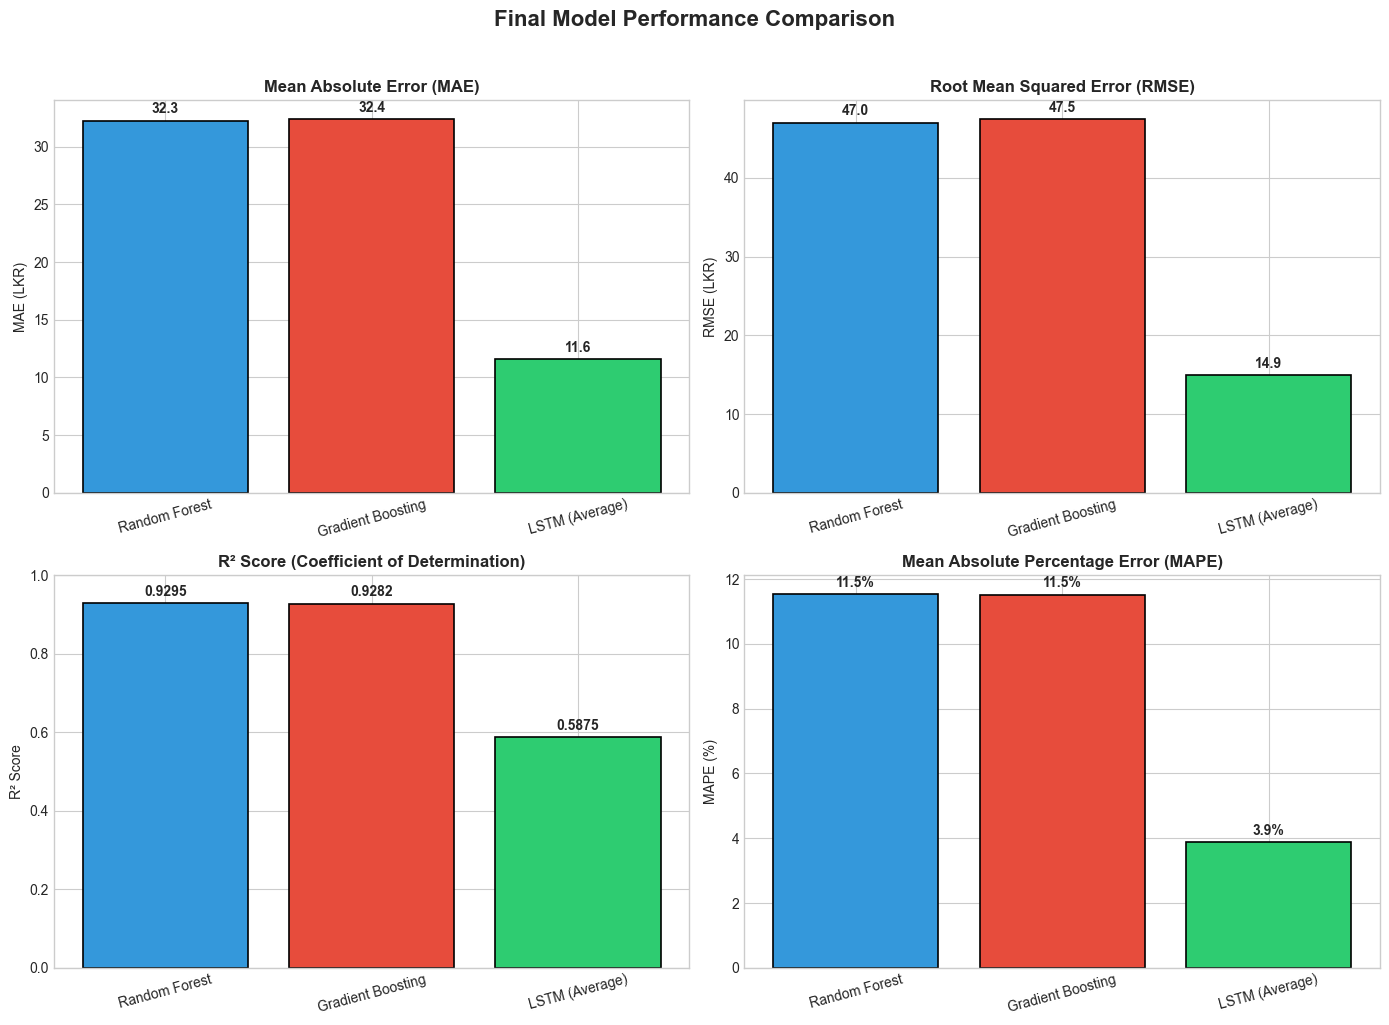

In [122]:
# Final visualization - Model Performance Summary
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Color palette
model_colors = {'Random Forest': '#3498db', 'Gradient Boosting': '#e74c3c', 'LSTM (Average)': '#2ecc71'}
colors = [model_colors[m] for m in final_comparison['Model']]

# 1. MAE Comparison
ax1 = axes[0, 0]
bars = ax1.bar(final_comparison['Model'], final_comparison['MAE (LKR)'], color=colors, edgecolor='black', linewidth=1.2)
ax1.set_title('Mean Absolute Error (MAE)', fontsize=12, fontweight='bold')
ax1.set_ylabel('MAE (LKR)')
for bar in bars:
    height = bar.get_height()
    ax1.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontweight='bold')
ax1.tick_params(axis='x', rotation=15)

# 2. RMSE Comparison
ax2 = axes[0, 1]
bars = ax2.bar(final_comparison['Model'], final_comparison['RMSE (LKR)'], color=colors, edgecolor='black', linewidth=1.2)
ax2.set_title('Root Mean Squared Error (RMSE)', fontsize=12, fontweight='bold')
ax2.set_ylabel('RMSE (LKR)')
for bar in bars:
    height = bar.get_height()
    ax2.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontweight='bold')
ax2.tick_params(axis='x', rotation=15)

# 3. R² Score Comparison
ax3 = axes[1, 0]
bars = ax3.bar(final_comparison['Model'], final_comparison['R² Score'], color=colors, edgecolor='black', linewidth=1.2)
ax3.set_title('R² Score (Coefficient of Determination)', fontsize=12, fontweight='bold')
ax3.set_ylabel('R² Score')
ax3.set_ylim(0, 1)
for bar in bars:
    height = bar.get_height()
    ax3.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontweight='bold')
ax3.tick_params(axis='x', rotation=15)

# 4. MAPE Comparison
ax4 = axes[1, 1]
bars = ax4.bar(final_comparison['Model'], final_comparison['MAPE (%)'], color=colors, edgecolor='black', linewidth=1.2)
ax4.set_title('Mean Absolute Percentage Error (MAPE)', fontsize=12, fontweight='bold')
ax4.set_ylabel('MAPE (%)')
for bar in bars:
    height = bar.get_height()
    ax4.annotate(f'{height:.1f}%', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontweight='bold')
ax4.tick_params(axis='x', rotation=15)

plt.suptitle('Final Model Performance Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

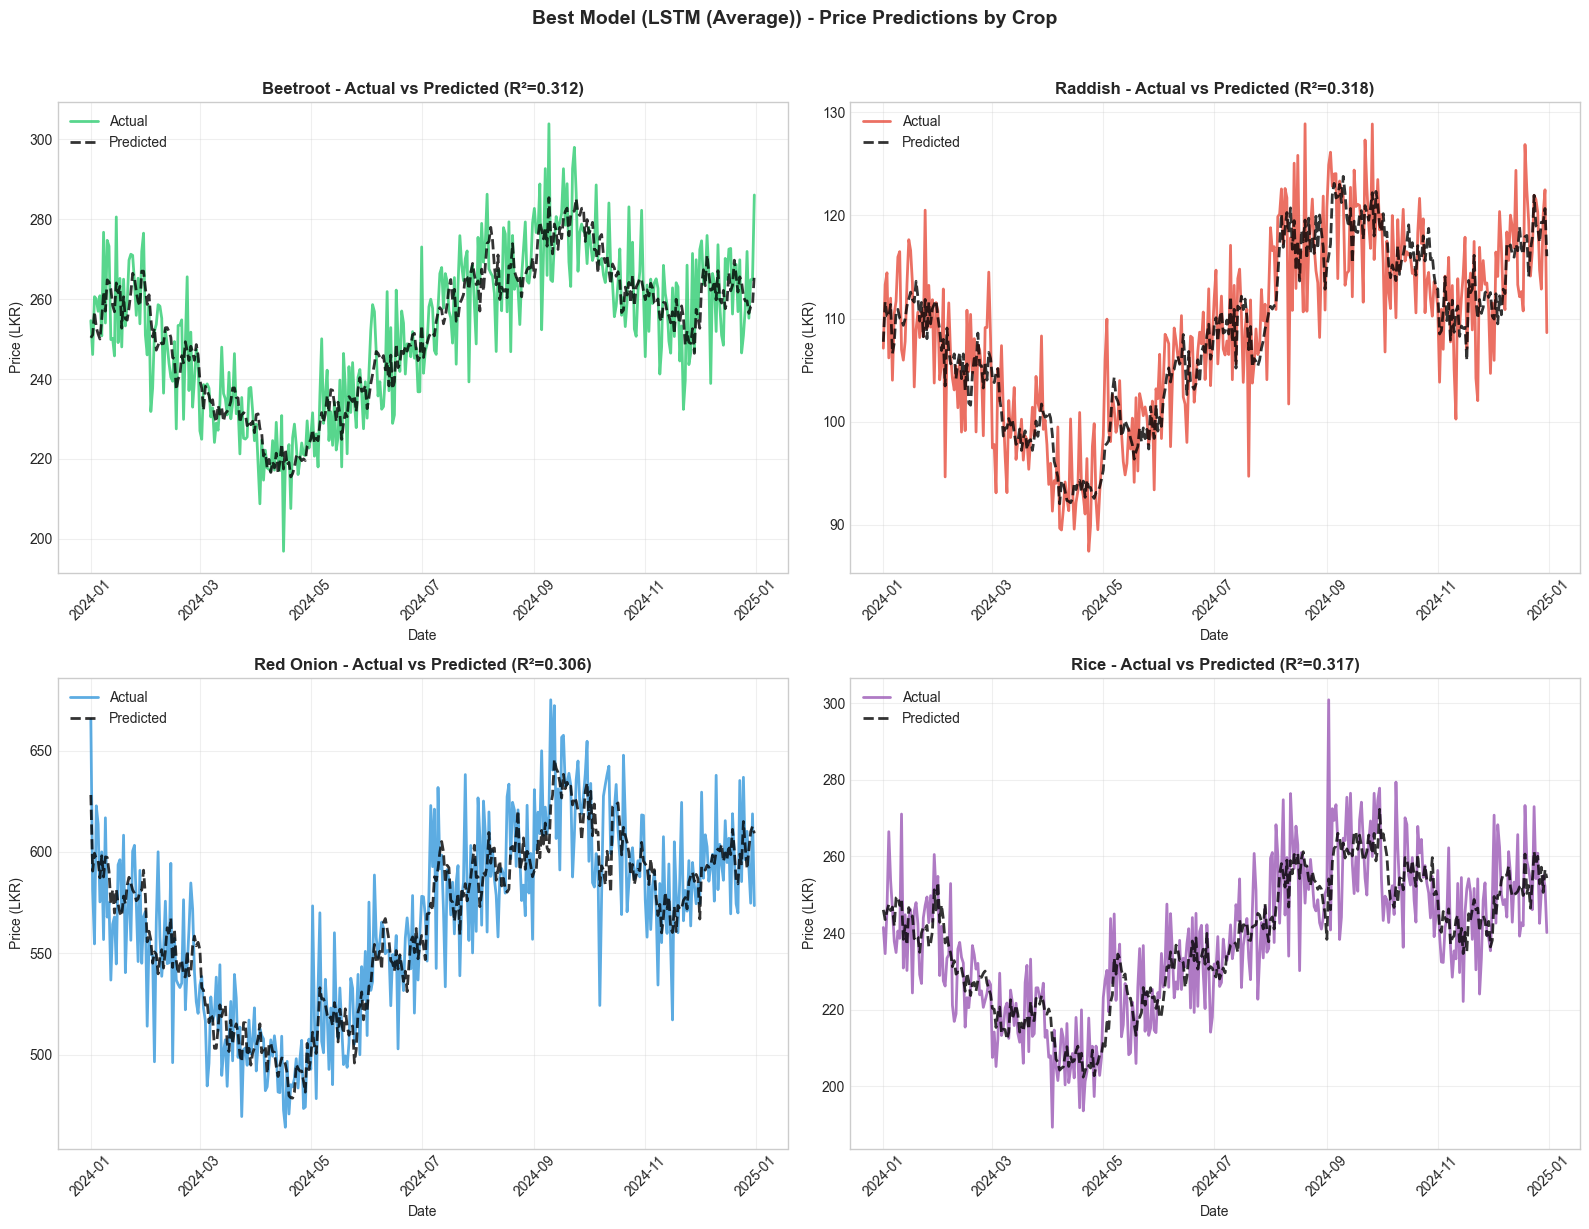

In [123]:
# Prediction Plots - Actual vs Predicted for Best Model
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Get test data with predictions
test_results = df_model.iloc[split_idx:].copy()
test_results['predicted_price'] = y_pred_rf if rf_rmse <= gb_rmse else y_pred_gb

crops = df_model['item'].unique()
colors = ['#2ecc71', '#e74c3c', '#3498db', '#9b59b6']

for idx, crop in enumerate(crops):
    ax = axes[idx // 2, idx % 2]
    crop_data = test_results[test_results['item'] == crop].copy()
    
    # Daily average for cleaner plot
    daily_data = crop_data.groupby('Date').agg({
        'price': 'mean',
        'predicted_price': 'mean'
    }).reset_index()
    
    ax.plot(daily_data['Date'], daily_data['price'], label='Actual', alpha=0.8, linewidth=2, color=colors[idx])
    ax.plot(daily_data['Date'], daily_data['predicted_price'], label='Predicted', alpha=0.8, linewidth=2, linestyle='--', color='black')
    
    # R² for this crop
    crop_r2 = r2_score(crop_data['price'], crop_data['predicted_price'])
    
    ax.set_title(f'{crop} - Actual vs Predicted (R²={crop_r2:.3f})', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price (LKR)')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.suptitle(f'Best Model ({best_by_rmse}) - Price Predictions by Crop', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()